In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plot
from tensorflow.examples.tutorials.mnist import input_data

In [0]:
def conv2d(x, output, kernel_size, strides, name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w',
                            [kernel_size, kernel_size, x.get_shape()[-1], output],
                            initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable('b',
                            [output],
                            initializer=tf.constant_initializer(0.0))

        return tf.nn.conv2d(x, w, strides=strides, padding='SAME') + b


def deconv_2d(x, output_shape, kernel_size, strides, name="deconv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w',
                            [kernel_size, kernel_size, output_shape[-1], x.get_shape()[-1]],
                            initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable('b',
                            [output_shape[-1]],
                            initializer=tf.constant_initializer(0.0))

        return tf.nn.conv2d_transpose(x, w,
                                      output_shape=output_shape,
                                      strides=strides,
                                      padding='SAME') + b


def instance_norm(x, name='instance_norm'):
    with tf.variable_scope(name):
        depth = x.get_shape()[-1]

        scale = tf.get_variable('scale', [depth],
                                initializer=tf.random_normal_initializer(1.0, 0.02,
                                                                         dtype=tf.float32))
        offset = tf.get_variable('offset', [depth],
                                 initializer=tf.constant_initializer(0.0))

        mean, variance = tf.nn.moments(x, axes=[1, 2], keep_dims=True)

        epsilon = 1e-5
        inv = tf.rsqrt(variance + epsilon)
        normalized = (x - mean) * inv

        return scale * normalized + offset


def relu(x, name='relu'):
    return tf.nn.relu(x)


def lrelu(x, leak=0.02, name='lrelu'):
    return tf.maximum(x, leak * x)


def tanh(x, name='tanh'):
    return tf.nn.tanh(x)

In [0]:
batch_size = 32
X_dim = 784
c_dim = 10
h_dim = 1024
d_steps = 5
lamda_cls = 0.1
lamda_rec = 0.1

In [4]:
mnist = input_data.read_data_sets('../../MNIST_data/', one_hot=True)

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
def plot_images(samples):
    fig = plot.figure(figsize=(8, 4))
    gs = gridspec.GridSpec(8, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plot.subplot(gs[i])
        plot.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plot.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [0]:
def discriminator(x, reuse=False):
    with tf.variable_scope("discriminator"):
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False
        
        x = tf.reshape(x, [-1, 28, 28, 1])
        
        x = lrelu(conv2d(x, 64, kernel_size=4, strides=[1, 2, 2, 1], name='disc_conv_1'))
        x = lrelu(conv2d(x, 128, kernel_size=4, strides=[1, 2, 2, 1], name='disc_conv_2'))
        x = lrelu(conv2d(x, 256, kernel_size=4, strides=[1, 2, 2, 1], name='disc_conv_3'))
        
        x = conv2d(x, 1+10, kernel_size=1, strides=[1, 1, 1, 1], name='disc_conv_4')
        x = tf.reshape(tf.reduce_mean(x,axis=[1, 2]), [-1, 1 + 10])
        src = x[:,0]
        cls = x[:,1:]
        return src, cls

In [0]:
def generator(x, c, reuse=False):
    with tf.variable_scope("generator"):
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False
        
        c = tf.tile(tf.reshape(c, [32, 1, 1, 10]), multiples=[1, 28, 28, 1])
        x = tf.reshape(x, [32, 28, 28, 1])
        x = tf.concat([x, c], axis=3)
        
        x = relu(instance_norm(conv2d(x, 64, kernel_size=7, strides=[1, 1, 1, 1], 
                                      name='gen_ds_conv1'), 'in1_1'))
        x = relu(instance_norm(conv2d(x, 128, kernel_size=4,strides=[1, 2, 2, 1], 
                                      name='gen_ds_conv2'), 'in1_2'))
        x = relu(instance_norm(conv2d(x, 256, kernel_size=4, strides=[1, 2, 2, 1], 
                                      name='gen_ds_conv3'), 'in1_3'))
        
        x = relu(instance_norm(conv2d(x, 256, kernel_size=3, strides=[1, 1, 1, 1], 
                                      name='gen_bn_conv1'), 'in2_1'))
        x = relu(instance_norm(conv2d(x, 256, kernel_size=3, strides=[1, 1, 1, 1], 
                                      name='gen_bn_conv2'), 'in2_2'))
        x = relu(instance_norm(conv2d(x, 256, kernel_size=3, strides=[1, 1, 1, 1], 
                                      name='gen_bn_conv3'), 'in2_3'))
        
        x = relu(instance_norm(deconv_2d(x, [32, 14, 14, 128], kernel_size=4, strides=[1, 2, 2, 1], 
                                        name='gen_us_deconv1'), 'in3_1'))
        x = relu(instance_norm(deconv_2d(x, [32, 28, 28, 64], kernel_size=4, strides=[1, 2, 2, 1], 
                                        name='gen_us_deconv2'), 'in3_2'))
        x = tanh(deconv_2d(x, [32, 28, 28, 1], kernel_size=7, strides=[1, 1, 1, 1], 
                          name='gen_us_deconv3'))
        
        return x

In [0]:
real_image = tf.placeholder(dtype=tf.float32, shape=[None, 784])
real_labels = tf.placeholder(dtype=tf.float32, shape=[None, c_dim])
fake_labels = tf.placeholder(dtype=tf.float32, shape=[None, c_dim])
alpha = tf.placeholder(dtype=tf.float32, shape=[None, 1, 1, 1])

In [0]:
fake_image = generator(real_image, fake_labels, False)
real_disc, real_class = discriminator(real_image)
fake_disc, fake_class = discriminator(fake_image, True)
rec_image = generator(fake_image, real_labels, True)

interpolated = alpha * tf.reshape(real_image, [32, 28, 28, 1]) + (1 - alpha) * fake_image
int_disc, int_cls = discriminator(interpolated, True)

In [0]:
gen_loss_fake = tf.reduce_mean(fake_disc)
gen_loss_rec = tf.reduce_mean(tf.abs(tf.reshape(real_image, [32, 28, 28, 1]) - rec_image))
gen_loss_class = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_class, labels=fake_labels))

gen_loss = gen_loss_fake + lamda_rec * gen_loss_rec + lamda_cls * gen_loss_class

In [0]:
disc_loss_real = tf.reduce_mean(real_disc)
disc_loss_cls = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_class, labels=real_labels))
disc_loss_fake = tf.reduce_mean(fake_disc)

grads = tf.gradients(int_disc, [interpolated])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,]))
grad_penalty = tf.reduce_mean(tf.square(slopes - 1.))
    
disc_loss = disc_loss_real + disc_loss_fake + 10 * grad_penalty + lamda_cls * disc_loss_cls

In [0]:
def generate_fake_label(batch_size):
    idx = np.random.randint(0, 10)
    c = np.zeros([batch_size, c_dim])
    c[range(batch_size), idx] = 1
    return c

In [0]:
def get_alpha(batch_size):
    return np.reshape(np.random.rand(batch_size, 1), [batch_size, 1, 1, 1])

In [0]:
all_vars = tf.trainable_variables()
generator_vars = [var for var in all_vars if var.name.startswith('gen')]
discriminator_vars = [var for var in all_vars if var.name.startswith('disc')]

g_optim = tf.train.AdamOptimizer(0.001).minimize(gen_loss, var_list=generator_vars)

d_optim = tf.train.AdamOptimizer(0.001).minimize(disc_loss, var_list=discriminator_vars)

In [0]:
init = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init)

Epoch: 0, Iteration: 0: G: -0.685685932636261 ; D: 9.329577445983887
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


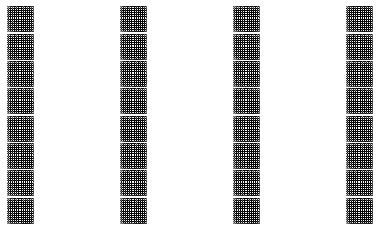

Epoch: 0, Iteration: 100: G: -103577536.0 ; D: -200147120.0
Epoch: 0, Iteration: 200: G: -989013952.0 ; D: -1839829504.0


KeyboardInterrupt: ignored

In [16]:
for epoch in range(10):
    for it in range(50000 // 32):
        for i in range(d_steps):
            x_batch, y_batch = mnist.train.next_batch(32)
            _, d_loss = sess.run([d_optim, disc_loss], feed_dict={
                real_image: x_batch,
                real_labels: y_batch,
                fake_labels: generate_fake_label(32),
                alpha: get_alpha(32)
            })

        x_batch, y_batch = mnist.train.next_batch(32)
        _, g_loss = sess.run([g_optim, gen_loss], feed_dict={
            real_image: x_batch,
            real_labels: y_batch,
            fake_labels: generate_fake_label(32),
        })
        if it % 100 == 0:
            print('Epoch: {}, Iteration: {}: G: {} ; D: {}'.format(epoch, it, g_loss, d_loss))
        

            if it % 1000 == 0:
                x_batch, y_batch = mnist.train.next_batch(32)
        
                c = generate_fake_label(32)
                print(c[0])
                samples = sess.run(fake_image, feed_dict={
                    real_image: x_batch,
                    fake_labels: c
                })

                fig = plot_images(samples)
                plot.show()
                plot.close(fig)
